In [4]:
using HierarchicalDriving
import POMDPs:initial_state
using POMDPToolbox
using Interact
using MCTS
using AutoViz
import ParticleFilters: obs_weight
import Base: ==, +, *, -, <, >, copy, Random, hash

In [5]:
HORIZON = 13
TIME_STEP = 0.3
lb_x = (AVG_HWY_VELOCITY - 5.0) * TIME_STEP * HORIZON
ub_x = (AVG_HWY_VELOCITY + 5.0) * TIME_STEP * HORIZON
p = LowLevelMDP(0.99,TIME_STEP, HORIZON,
                            HierarchicalDriving.RoadSegment((-100.0, 500.0),[0.0, LANE_WIDTH, 2.0 * LANE_WIDTH, 3.0 * LANE_WIDTH, 4.0 * LANE_WIDTH]),
                            CarPhysicalState((0.0, 3.0 * LANE_WIDTH/2.0, AVG_HWY_VELOCITY)),
                            (CarPhysicalState((lb_x, 5.0 * LANE_WIDTH/2.0 - 0.5, AVG_HWY_VELOCITY - 5)),
                             CarPhysicalState((ub_x, 5.0 * LANE_WIDTH/2.0 + 0.5, AVG_HWY_VELOCITY + 5))),
                            50.0, -500.0, -1.0, -5.0, -5.0, -1.0, HierarchicalDriving.getFrameList());

In [3]:
function testing()
    n = 100
    sum = 0.0
    sum1 = 0.0
    numPositiveRnd = 0
    numPositiveMCTS = 0
    for i in 1:n
        #policy = RandomPolicy(p)
        policy = subintentional_lowlevel_policy(p)
        hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist = simulate(hr, p, policy)
        finState = state_hist(hist)[end]

        solver = DPWSolver(depth=p.HORIZON,
                             exploration_constant=10.0,
                             n_iterations=1_000,
                             k_action=10.0,
                             alpha_action=1/10,
                             k_state=5.0,
                             alpha_state=1/10,
                             estimate_value=RolloutEstimator(subintentional_lowlevel_policy(p))
                              )
        policy1 = solve(solver, p)
        hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
        hist1 = simulate(hr1, p, policy1)
        finState1 = state_hist(hist1)[end]
        

        println(i, ",", discounted_reward(hist), ",", discounted_reward(hist1))
        sum += discounted_reward(hist)
        sum1+= discounted_reward(hist1)
        if finState.terminal == 2 || HierarchicalDriving.checkTargetCoordinates(finState,p)
            numPositiveRnd += 1
        end
        if finState1.terminal == 2 || HierarchicalDriving.checkTargetCoordinates(finState1,p)
            numPositiveMCTS += 1
        end
    end
    println("Mean: ",sum/n,",", sum1/n)
    println("Success Rate: ", numPositiveRnd/n, ",", numPositiveMCTS/n)
end

testing (generic function with 1 method)

In [4]:
@time testing()

1,0.0,0.0
2,42.578471678092534,43.30734100047738
3,0.0,-11.94182358389959
4,0.0,0.0
5,42.578471678092534,42.90551697417685
6,0.0,37.82054729521708
7,0.0,31.894574885585882
8,0.0,-0.16777176262325807
9,42.578471678092534,42.781615360477375
10,42.578471678092534,43.20552510323253
11,0.0,37.04474561328291
12,42.516913362660205,42.98125051350385
13,0.0,-0.1781999999999999
14,42.578471678092534,42.871074796989156
15,0.0,37.20050808924028
16,42.578471678092534,42.267710229019265
17,0.0,-1.3989580472736733
18,42.578471678092534,43.20552510323253
19,0.0,43.20197892323253
20,0.0,32.2543802786937
21,-0.4802594395843751,40.96918394468859
22,-1.3989580472736733,42.60341536047738
23,42.578471678092534,41.77253616443508
24,0.0,42.89846007597685
25,42.578471678092534,42.36735596098788
26,0.0,32.32261763276788
27,42.578471678092534,42.644129295217084
28,0.0,37.20050808924028
29,42.578471678092534,42.81681187248863
30,42.80142966771746,42.570748743216924
31,0.0,0.0
32,42.578471678092534,43.057349341128

Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(7, nactions=1),"i",7,"7",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

StepNo 1
3
3
StepNo 2
3
3
StepNo 3
3
3
StepNo 4
3
3
StepNo 5
3
3
StepNo 6
3
3
StepNo 7
3
3
StepNo 8
1
1
StepNo 9
1
1
StepNo 10
1
1
StepNo 11
1
1
StepNo 12
1
1


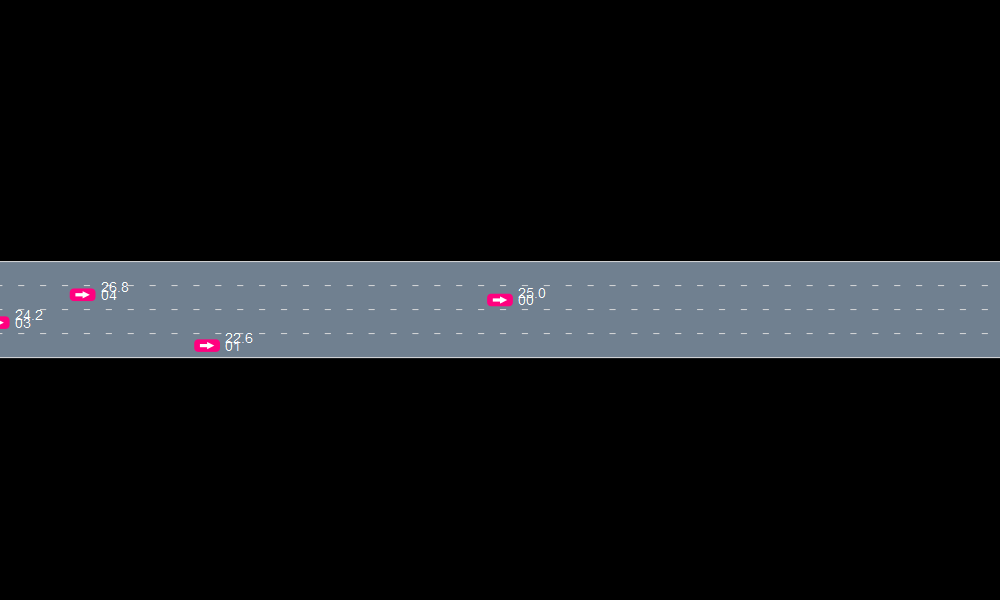

In [16]:
i = 2
#policy = RandomPolicy(p)
policy = subintentional_lowlevel_policy(p);
hr = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i));
hist = simulate(hr, p, policy);
for stepno in 1:n_steps(hist)
    act = action(policy, state_hist(hist)[stepno])
    println("StepNo $stepno")
    println(act)
    println(action(policy, state_hist(hist)[stepno]))
end
@manipulate for i in 1:n_steps(hist)+1
    (p,state_hist(hist)[i],SceneOverlay[CarVelOverlay(), CarIDOverlay()])
end

  2.805139 seconds (31.56 M allocations: 882.842 MB, 15.54% gc time)
StepNo 1
  0.428255 seconds (6.09 M allocations: 166.077 MB, 10.69% gc time)
8
3
StepNo 2
  0.463588 seconds (5.35 M allocations: 147.054 MB, 11.07% gc time)
9
3
StepNo 3
  0.408553 seconds (4.68 M allocations: 129.064 MB, 10.77% gc time)
9
3
StepNo 4
  0.318869 seconds (4.04 M allocations: 112.400 MB, 10.71% gc time)
6
3
StepNo 5
  0.276868 seconds (3.34 M allocations: 93.826 MB, 10.24% gc time)
6
3
StepNo 6
  0.449676 seconds (2.74 M allocations: 77.682 MB, 49.54% gc time)
9
3
StepNo 7
  0.219736 seconds (2.17 M allocations: 62.393 MB, 8.43% gc time)
9
3
StepNo 8
  0.153162 seconds (1.59 M allocations: 46.456 MB, 8.34% gc time)
1
1
StepNo 9


Interact.Options{:SelectionSlider,Int64}(Signal{Int64}(6, nactions=1),"i",6,"6",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",7=>"7",9=>"9",10=>"10",8=>"8",6=>"6",4=>"4",3=>"3",5=>"5"…)),Any[],Any[],true,"horizontal")

  0.104236 seconds (1.24 M allocations: 36.840 MB, 5.91% gc time)
4
1
StepNo 10
  0.054883 seconds (477.16 k allocations: 14.864 MB, 8.64% gc time)
2
1
StepNo 11
  0.002083 seconds (32.47 k allocations: 1.226 MB)
6
1


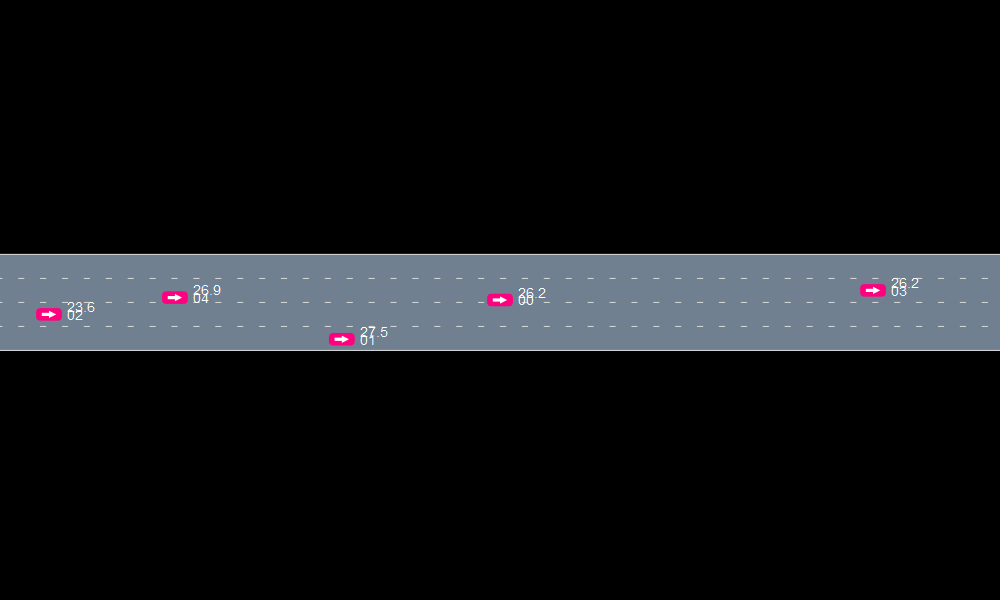

In [23]:
solver = DPWSolver(depth=p.HORIZON,
                             exploration_constant=10.0,
                             n_iterations=1_000,
                             k_action=10.0,
                             alpha_action=1/10,
                             k_state=5.0,
                             alpha_state=1/10,
                             estimate_value=RolloutEstimator(subintentional_lowlevel_policy(p))
                          )
policy1 = solve(solver, p)
hr1 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
hr2 = HistoryRecorder(max_steps = p.HORIZON, rng = MersenneTwister(i))
@time (hist1 = simulate(hr1, p, policy1);)
#@time (hist2 = simulate(hr2, p, policy1);)
for i in 1:n_steps(hist1)
    println("StepNo $i")
   @time (act = action(policy1, state_hist(hist1)[i]))
    
    println(act) 
    println(action(policy, state_hist(hist)[i]))
end
@manipulate for i in 1:n_steps(hist1)+1
    (p,state_hist(hist1)[i])
end

In [5]:
sh = state_hist(hist1)[end]
println(sh.ego)

HierarchicalDriving.CarPhysicalState((64.31508314322822,10.199999999999998,26.36390749962482))


In [6]:
discounted_reward(hist)

0.0

In [6]:
discounted_reward(hist1)

34.123558845652454